#**Лабораторная работа по ММАД №3**

##**Выполнил: Степанищев Степан Владимирович, гр. 23171**

##***Задание 1***

###Скачиваем обучающую и тестовую выборки в соответствии с 7 вариантом (House Price Prediction Challenge) https://www.kaggle.com/datasets/anmolkumar/house-price-prediction-challenge

---

###Подключаем библиотеки

---

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

###Проанализируем набор данных: статистику по переменным, количество объектов, количество пропущенных значений.

---


In [46]:
train_df = pd.read_csv('/content/train.csv')

train_X = train_df.drop('TARGET(PRICE_IN_LACS)', axis=1)
train_Y = train_df['TARGET(PRICE_IN_LACS)']

print("Количество объектов: ", len(train_df), "\n")
print("Количество пропущенных значений: ")
display(train_X.isna().sum())
print("\n")

print("Статистика по переменным: ")
display(train_X.describe())
print("\n")

Количество объектов:  29451 

Количество пропущенных значений: 


POSTED_BY             0
UNDER_CONSTRUCTION    0
RERA                  0
BHK_NO.               0
BHK_OR_RK             0
SQUARE_FT             0
READY_TO_MOVE         0
RESALE                0
ADDRESS               0
LONGITUDE             0
LATITUDE              0
dtype: int64



Статистика по переменным: 


,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE
count,29451.000000,29451.000000,29451.000000,2.945100e+04,29451.000000,29451.000000,29451.000000,29451.000000
mean,0.179756,0.317918,2.392279,1.980217e+04,0.820244,0.929578,21.300255,76.837695
std,0.383991,0.465675,0.879091,1.901335e+06,0.383991,0.255861,6.205306,10.557747
min,0.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,-37.713008,-121.761248
25%,0.000000,0.000000,2.000000,9.000211e+02,1.000000,1.000000,18.452663,73.798100
50%,0.000000,0.000000,2.000000,1.175057e+03,1.000000,1.000000,20.750000,77.324137
75%,0.000000,1.000000,3.000000,1.550688e+03,1.000000,1.000000,26.900926,77.828740
max,1.000000,1.000000,20.000000,2.545455e+08,1.000000,1.000000,59.912884,152.962676


###Визуализируем распределения признаков.

---


In [47]:
uv = train_X['ADDRESS'].unique()
display(len(uv))

6899

Поле ADDRESS имеет слишком много уникальных значений, поэтому его визуализировать не будем.

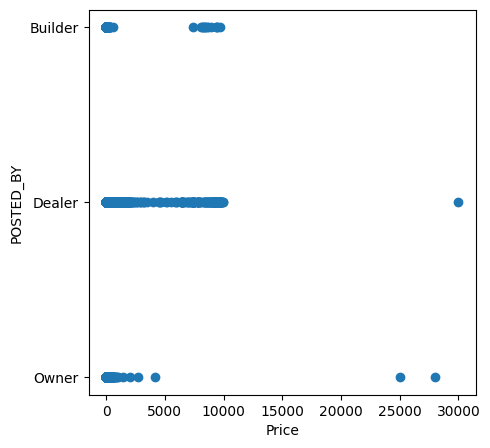

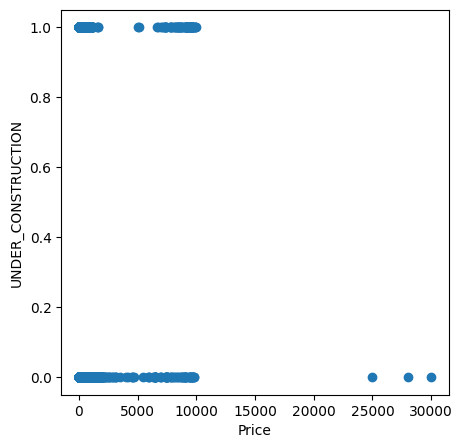

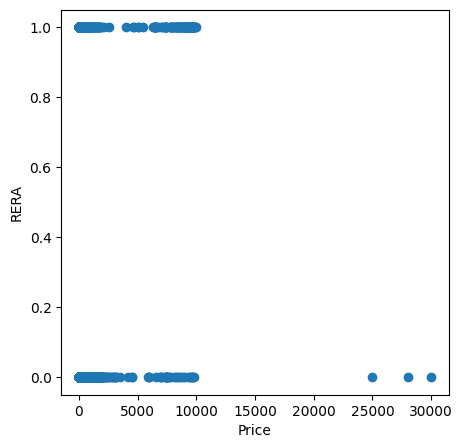

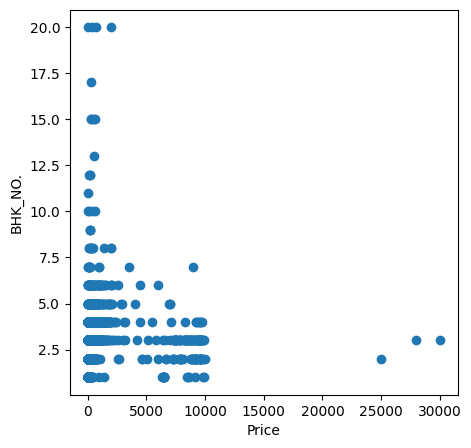

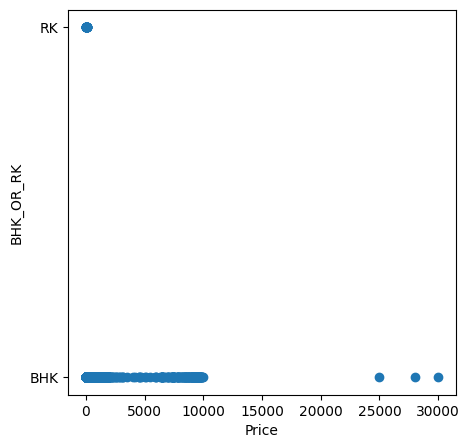

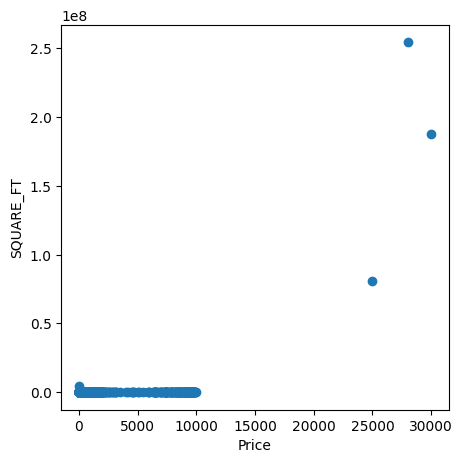

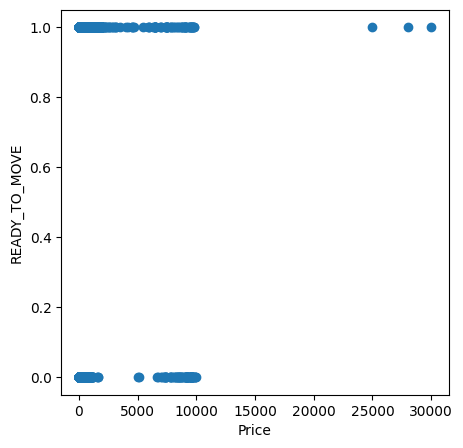

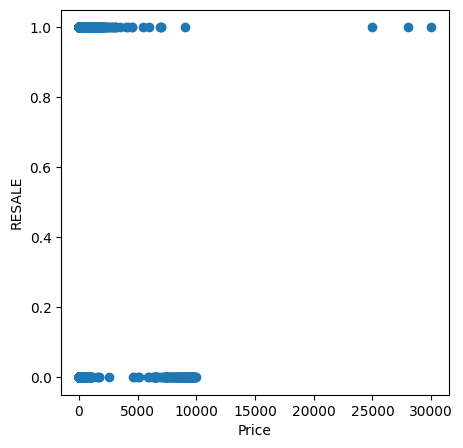

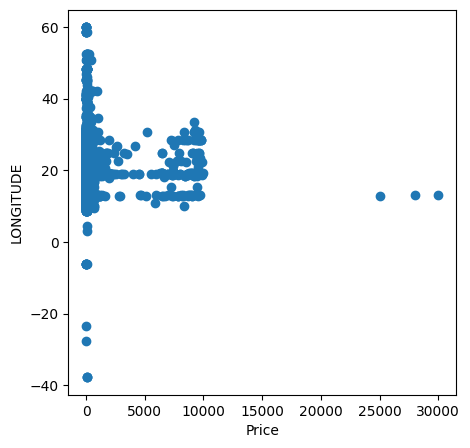

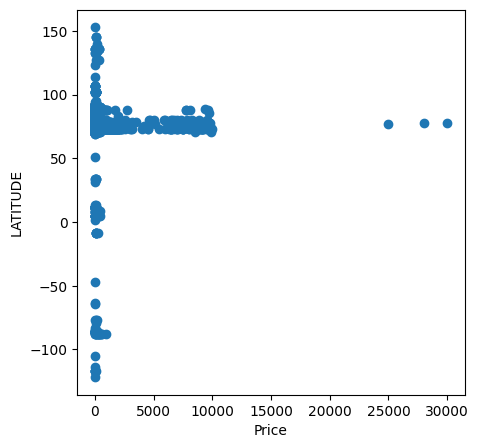

In [48]:
scale = 5
for col in train_X.columns.drop('ADDRESS'):
  fig, ax = plt.subplots(figsize = (scale, scale))
  ax.scatter(train_Y, train_X[col])
  ax.set_ylabel(col)
  ax.set_xlabel('Price')

**Вывод:** из таблицы и графиков видим большое количество аномальных значений.

###Избавляемся от аномальных значений с помощью правила трёх сигм. И заодно уберем дубликаты.

---


In [49]:
def clear_df(df) -> pd.DataFrame:
  display("Data frame size before update: ", df.shape)
  df.drop_duplicates(inplace=True)

  numeric_cols = df.select_dtypes(['int', 'float'])
  z = np.abs(stats.zscore(numeric_cols))
  new_df = df[(z < 3).all(axis = 1)]
  display("Data frame size after update: ", new_df.shape)

  return new_df

In [50]:
train_df = clear_df(train_df)


'Data frame size before update: '

(29451, 12)

'Data frame size after update: '

(26681, 12)

###Оценим корреляции

---

In [51]:
train_X_numeric = train_X.loc[:, ['BHK_NO.', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE']]
display('Корреляции числовых признаков с ценой:')
display(train_X_numeric.corrwith(train_Y))
print()
display('Корреляции числовых признаков между собой:')
display(train_X_numeric.corr())


'Корреляции числовых признаков с ценой:'

BHK_NO.      0.112283
SQUARE_FT    0.402685
LONGITUDE   -0.031112
LATITUDE    -0.017254
dtype: float64

'Корреляции числовых признаков между собой:'

,BHK_NO.,SQUARE_FT,LONGITUDE,LATITUDE
BHK_NO.,1.000000,0.005303,0.068730,0.046930
SQUARE_FT,0.005303,1.000000,-0.012591,0.000803
LONGITUDE,0.068730,-0.012591,1.000000,-0.155062
LATITUDE,0.046930,0.000803,-0.155062,1.000000


**Вывод:** долгота и широта никак не коррелируют с ценой, номер комнат коррелирует слабо, а квадратура умеренно. Что странно, между собой эти признаки вообще не коррелируют, хотя, как мне кажется, количество комнат явно должно коррелировать с квадратурой дома.

##***Задание 2***

###Строим логистическую регрессию

---

Признак ADDRESS имеет большое количество уникальных значений. В лучшем случае, модель переобучится на тренировочных данных, в худшем, мы не сможем построить регрессию вообще. Более того, в тестовой выборке могут быть объекты со значениями поля ADDRESS, которых нет в тренировочной выборке.

In [52]:
train_X = train_df.drop(['TARGET(PRICE_IN_LACS)', 'ADDRESS'], axis=1)
train_Y = train_df['TARGET(PRICE_IN_LACS)']

encoded_train_X = pd.get_dummies(train_X)

Так как мы убрали аномальные значения, а пропущенных значений у нас нет, то нам подойдет обычный метод наименьших квадратов (OLS). Удобно пользоваться библиотекой statsmodels, так как она предоставляет информативное summary.

In [53]:
model_linear_ols = sm.OLS(train_Y, sm.add_constant(encoded_train_X))
result_linear_ols = model_linear_ols.fit()
print(result_linear_ols.summary())

                              OLS Regression Results                             
Dep. Variable:     TARGET(PRICE_IN_LACS)   R-squared:                       0.262
Model:                               OLS   Adj. R-squared:                  0.261
Method:                    Least Squares   F-statistic:                     1050.
Date:                   Thu, 23 Nov 2023   Prob (F-statistic):               0.00
Time:                           15:18:27   Log-Likelihood:            -1.6437e+05
No. Observations:                  26681   AIC:                         3.288e+05
Df Residuals:                      26671   BIC:                         3.288e+05
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
UNDER_

**Вывод:** значение Prob (F-statistic) < 0.05, поэтому гипотеза R-squared = 0 отвергается, что значит, что модель значима. Но уровень значимости невысокий, т.е. модель только на 26.2% соответствует данным, на которых она построена. Коэффициенты признаков, у которых расчетный уровень значимости выше 0.05, считаем незначимыми: POSTED_BY_Builder, SQUARE_FT, RERA.

Выявим наиболее информативные признаки с помощью p-values

In [54]:
display(result_linear_ols.pvalues.sort_values().index[:10])


Index(['BHK_NO.', 'LATITUDE', 'LONGITUDE', 'READY_TO_MOVE', 'RESALE',
       'UNDER_CONSTRUCTION', 'POSTED_BY_Dealer', 'BHK_OR_RK_BHK',
       'BHK_OR_RK_RK', 'POSTED_BY_Owner'],
      dtype='object')

##***Задание 3***

###Строим градиентный бустинг

---

Я только что заметил, что у нас у тестовой выборки нету значений таргета, поэтому просто разделим тренировочную выборку.

In [55]:
new_train_X, new_test_X, new_train_Y, new_test_Y = train_test_split(encoded_train_X, train_Y, test_size=0.3)

Строим градиентный бустинг.

In [56]:
model_grad_boost = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
model_grad_boost.fit(new_train_X, new_train_Y)
pred_Y_gb = model_grad_boost.predict(new_test_X)

Обучаем модель линейной регрессии на тех же данных и сравниваем точность, используя 5-fold кросс-валидацию.

In [57]:
model_linear_reg = LinearRegression()
model_linear_reg.fit(new_train_X, new_train_Y)
pred_Y_lr = model_linear_reg.predict(new_test_X)

k = 5
cv_gb = cross_val_score(model_grad_boost, encoded_train_X, train_Y, cv=k, n_jobs = -1)
cv_lr = cross_val_score(model_linear_reg, encoded_train_X, train_Y, cv=k, n_jobs = -1)

display('Mean 5-fold cv of Gradient Boosting: ', np.mean(cv_gb))
display('Mean 5-fold cv of Linear Regression: ', np.mean(cv_lr))

'Mean 5-fold cv of Gradient Boosting: '

0.5689636650517983

'Mean 5-fold cv of Linear Regression: '

0.25538069445656986

**Вывод:** исходя из кросс-валдиационных значений, градиентный бустинг оказался более подходящим методом для наших данных.

##***Задание 4***

###Рисуем

---

Так как в этой задаче у нас всего 4 количественных переменных, то просто нарисуем зависимости для них всех.

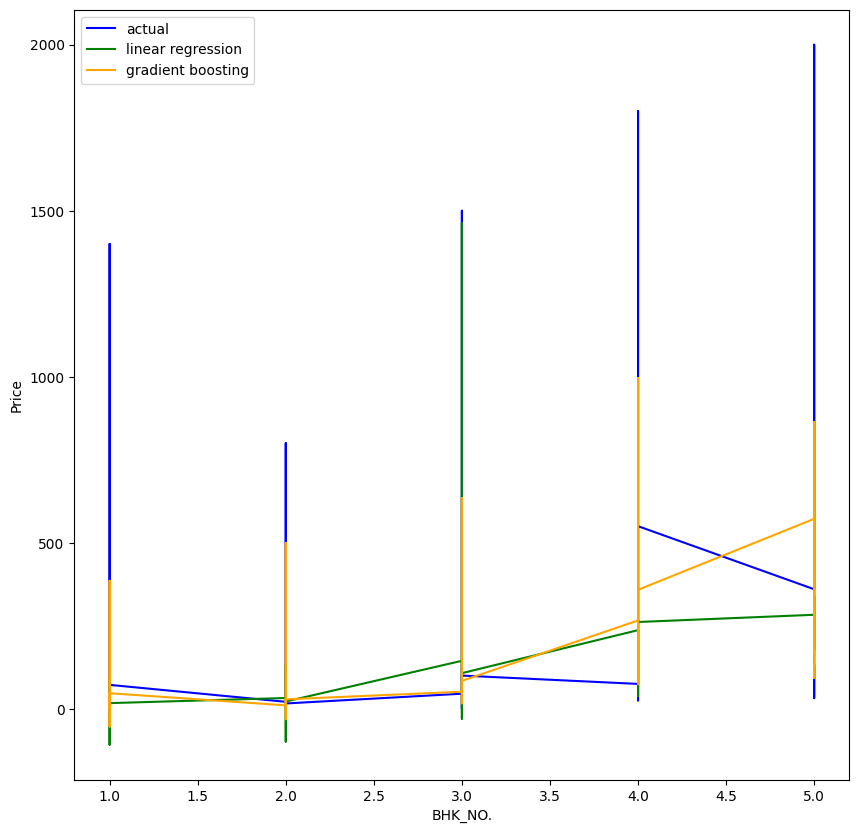

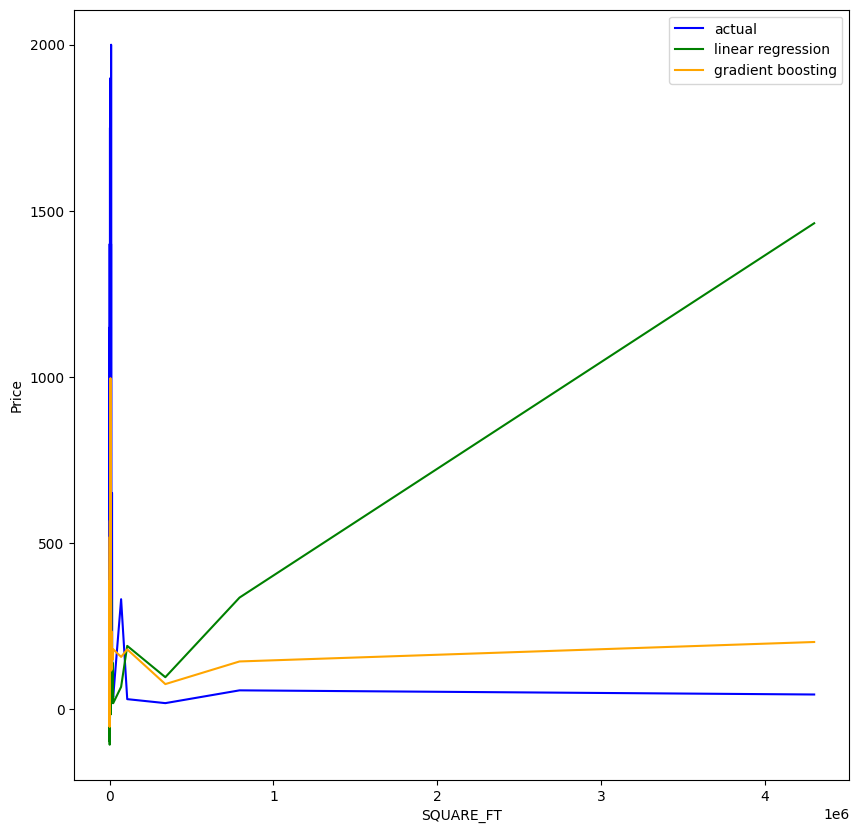

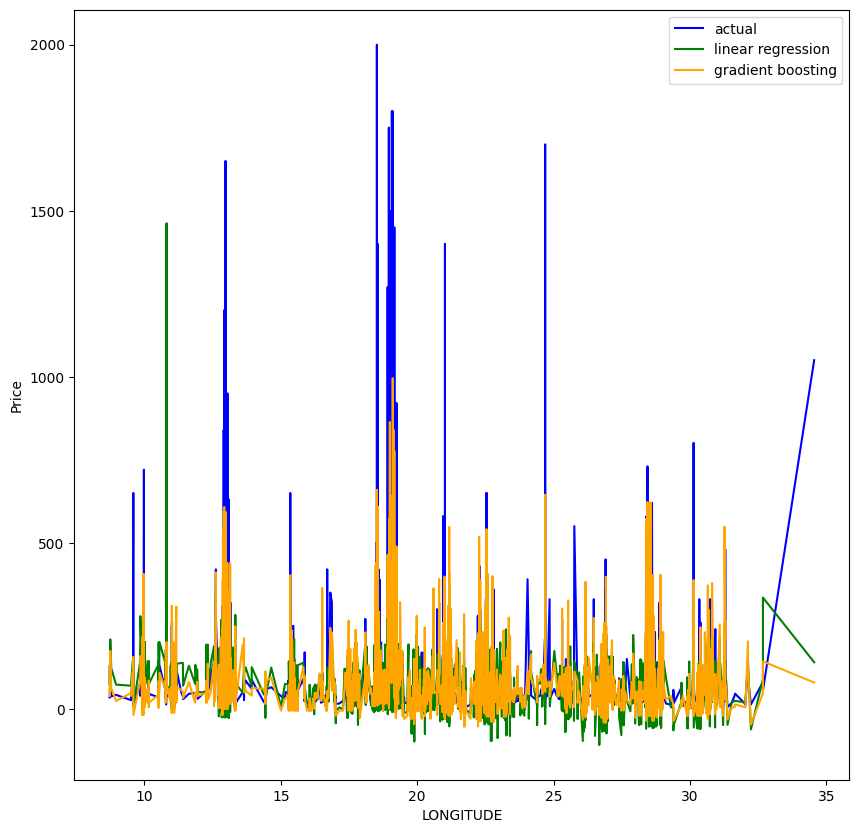

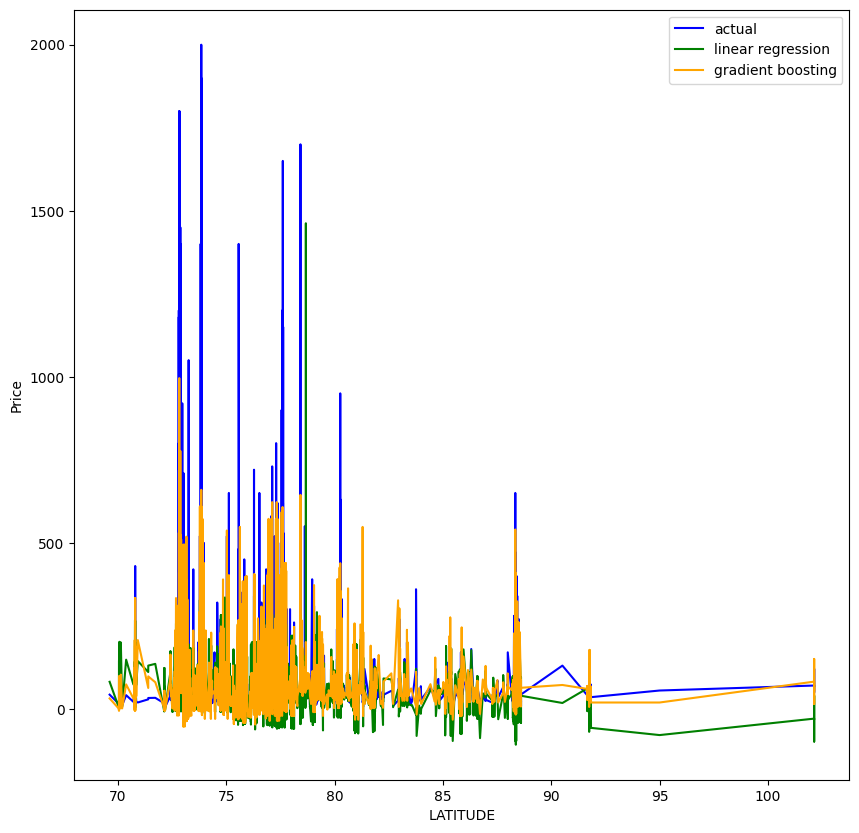

In [63]:
scale = 10

new_test_df = pd.concat((new_test_X, new_test_Y), axis = 1)
cols = ['BHK_NO.', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE']
for col in cols:
  fig, ax = plt.subplots(figsize = (scale, scale))
  tmp_df = new_test_df.sort_values(by=[col])
  X = tmp_df[col]
  Y = tmp_df['TARGET(PRICE_IN_LACS)']
  ax.plot(X, Y, c='blue', linestyle='solid', label='actual')
  Y = model_linear_reg.predict(tmp_df.drop(columns=['TARGET(PRICE_IN_LACS)'], axis=1))
  ax.plot(X, Y, c='green', linestyle='solid', label='linear regression')
  Y = model_grad_boost.predict(tmp_df.drop(columns=['TARGET(PRICE_IN_LACS)'], axis=1))
  ax.plot(X, Y, c='orange', linestyle='solid', label='gradient boosting')
  ax.set_xlabel(col)
  ax.set_ylabel('Price')
  ax.legend()

**Вывод:** похоже на правду, но все-таки обе модели не идеально справились с датасетом. Так же на графиках в принципе видно, что бустинг показал себя лучше.